<h1>EDA and Preprocessing of the Sentinel2 (S2) and European Settlement Map (ESM) for Training</h1>

This notebook contains an exploratory data analysis `(EDA)` and dataset `preprocessing` of the Sentinel2 (S2) and European Settlement Map (ESM), for the purpose of Segmentation of build up areas to residential and non residentials.

Prerequisites:
1. Google Drive account with the downloaded images folder ("./S2")and matching Masks ("./ESM")
2. Sufficient space to save the preprocessed images and masks

**Input:** Downloaded Sentinel2 GeoTiff images, 11 Bands, 300x300 pixels
**Output:** Preprocessed GeoTiff images, 15 bands, 300x300 pixels

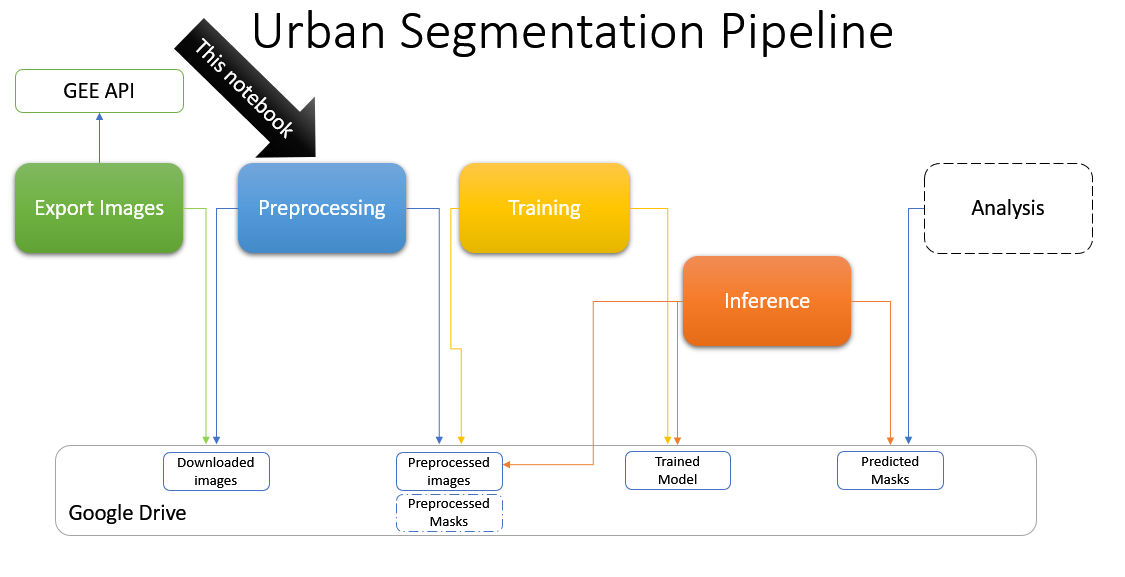

## Running instructions



1.   Connect to the NB
2.   Upload the ssh keys file on "Files" left side panel
3.   Update the downloaded images **input path** in "EXPORT_DIR" in the next cell
4.   Run the notebook to preprocess images and masks



In [1]:
# Create a path to the exported folder where the ESM and S2 directories were extracted to
#TODO >>>>>>>>>> CHANGE TO THE DOWNLOADED IMAGES DIRECTORY (INPUT)
EXPORT_DIR='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset'

#TODO >>>>>>>>>> Optional download dir for valiating the downloaded images vs. the original training images
# Change to None if you don't have such
DOWN_PREP_DIR = '/content/drive/MyDrive/gee_export_Jul_14_2022_1601_prep'

# Setup

Upload the Git credentials files on the left files panel (if using a secured)Git repo

Alternatively you can download the [Urban Segmentation Git](https://github.com/lleviraz/urban_segmentation) Repo as ZIP file, then upload and extract here 

In [2]:
import os
if(not os.path.exists('urban_segmentation')):
  if(os.path.exists('/root/.ssh')):
    !mv -f /root/.ssh /root/.ssh_old
  !unzip gitssh.zip && mv .ssh /root/ && chmod -R 400 /root/.ssh && ls /root/.ssh
  !git clone git@github.com:lleviraz/urban_segmentation.git

Archive:  gitssh.zip
   creating: .ssh/
  inflating: .ssh/id_ed25519         
 extracting: .ssh/id_ed25519.pub     
  inflating: .ssh/id_rsa             
  inflating: .ssh/id_rsa.pub         
  inflating: .ssh/known_hosts        
id_ed25519  id_ed25519.pub  id_rsa  id_rsa.pub	known_hosts
Cloning into 'urban_segmentation'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 169 (delta 63), reused 110 (delta 43), pack-reused 19
Receiving objects: 100% (169/169), 111.47 MiB | 27.93 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [4]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install rasterio torch -q

     |████████████████████████████████| 19.3 MB 3.1 MB/s 


In [6]:
import os
import sys
import glob
import numpy as np
import pprint as pp
import pandas as pd
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import rasterio as rio
from rasterio.plot import show_hist,show

# Dataset EDA

The dataset consists of 700 Satelite images images

S2 directory
------------
S2 is composed of Sentinel-2 images, exported with the follwowing 11 bands and represents mean values for the years 2017-2020 (from https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR)

- B1:  Blue
- B2:  Green
- B3:  Red
- B4:  Red Edge 1
- B5:  Red Edge 2
- B6:  Red Edge 3
- B7:  Near-Infrared (NIR)
- B8:  Red Edge 4
- B9:  Water vapor
- B10: Shortwave Infrared 1 (SWIR 1)
- B11: Shortwave Infrared 2 (SWIR 2)

Note: for displaying in RGB use a range between 0 and 0.3 for the red, green, and blue channels.

ESM directory
-------------
Contains the "Masks" which show the distinction between residential and non-residential areas (250 for non-residential and 255 for residential, 1 for all other areas, and 0 for "no data")

The original S2 and ESM raster types are not aligned in terms of spatial extent and resolution, therefore an alignment (projection) is done in this notebook to align the image Coordinates systems and  dimentsions

In [7]:
#Current working directory
#TODO >>>>>>>>>> IF NEEDED CHANGE TO THE CURRENT WORKING DIRECTORY OF THE NOTEBOOK
WORK_DIR = 'urban_segmentation/'
NB_DIR = WORK_DIR + 'notebooks/'
PREPROC_DIR = EXPORT_DIR + '_prepproc/'
META_DIR = EXPORT_DIR + '_metadata/'

# This directory is the parent of the "libs" directory which is imported below
# os.chdir(NB_DIR)
sys.path.append(NB_DIR)

#our common utils modules
from libs.common import *
from libs.bands import *

path = Path(EXPORT_DIR)
[f for f in path.iterdir()]

[PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM'),
 PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2'),
 PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM.zip'),
 PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned'),
 PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test'),
 PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized'),
 PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned_test')]

In [8]:
#Input folders - images and masks
S2_DIR = EXPORT_DIR + '/S2'
ESM_DIR = EXPORT_DIR + '/ESM'

esm_path = Path(ESM_DIR)
s2_path = Path(S2_DIR)

#Target folders - resized images and aligned masks
s2_resized = os.path.join(EXPORT_DIR,'s2_resized/')
esm_aligned = os.path.join(EXPORT_DIR ,'esm_aligned/')

#sample input image and mask
SAMPLE_IMAGE = Path(os.path.join(s2_path,'R_4_337.tif'))
SAMPLE_MASK = Path(os.path.join(esm_path,'ESM_337.tif'))
SAMPLE_IMAGE,SAMPLE_MASK

(PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_4_337.tif'),
 PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_337.tif'))

In [9]:
print('Number of input images:',len(glob.glob(S2_DIR + '/*.tif')))

Number of input images: 700


## Reading MultiChannel images (using Rasterio)

Unlike the common RGB images with 3 channels Red,Green and Blue, S2 images have multi channels (bands), in our case they were exported with 11 bands (with values are between 0 and 0.3)

Sample image and matching mask:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


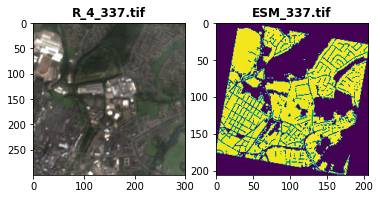

In [10]:
f,ax = plt.subplots(1,2)
s2_sample = display_image(SAMPLE_IMAGE,title=SAMPLE_IMAGE.name,ax=ax[0])
esm_sample = display_image(SAMPLE_MASK,bands=[1],title=SAMPLE_MASK.name,ax=ax[1])

ESM is the distinction between residential and non-residential areas (a "MASK"), here are the classes:

- 250 for non-residential
- 255 for residential
- 1 for all other areas
- 0 for no data

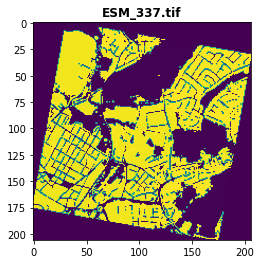

ESM_337.tif classes: [  0   1 250 255]
['class:0,count:1047300,24.68%:',
 'class:1,count:1261200,29.72%:',
 'class:250,count:801600,18.89%:',
 'class:255,count:1133500,26.71%:']
1  bands


In [11]:
display_image(SAMPLE_MASK,bands=[1],title=SAMPLE_MASK.name)
print_mask_stats(esm_sample,title=SAMPLE_MASK.name)

## Files metadata

ESM and S2 have a different spatial transform and resolution:

- `ESM` is `1x203x203`
- `S2` is `11x301x301`

In [12]:
print_image_metadata(esm_sample,SAMPLE_MASK.name)

ESM_337.tif Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 206, 'height': 206, 'count': 1, 'crs': CRS.from_epsg(3035), 'transform': Affine(10.0, 0.0, 3479760.0,
       0.0, -10.0, 3447380.0)}
ESM_337.tif Transform:
 | 10.00, 0.00, 3479760.00|
| 0.00,-10.00, 3447380.00|
| 0.00, 0.00, 1.00|


In [13]:
print_image_metadata(s2_sample,SAMPLE_IMAGE.name)

R_4_337.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, -304700.0,
       0.0, -10.0, 7069853.136509213)}
R_4_337.tif Transform:
 | 10.00, 0.00,-304700.00|
| 0.00,-10.00, 7069853.14|
| 0.00, 0.00, 1.00|


## RGB bands

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


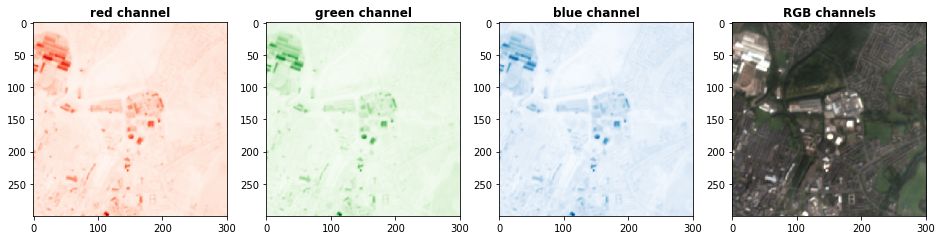

In [14]:
#Using rasterio - normalize RGB channels between 0 and 0.3 (the way they were extracted)
fig, (axr, axg, axb,axrgb) = plt.subplots(1,4, figsize=(16,5))
show(normalize(s2_sample.read(1)), ax=axr, cmap='Reds', title='red channel')
show(normalize(s2_sample.read(2)), ax=axg, cmap='Greens', title='green channel')
show(normalize(s2_sample.read(3)), ax=axb, cmap='Blues', title='blue channel')
show(normalize(s2_sample.read([3,2,1])), ax=axrgb, title='RGB channels')

## Plots of the different bands in a sample Sentinel2 image

|B1|B2|B3|B4|B5|B6|B7|B8|B9|B10|B11|
|-----|-------|--------|-----|-------|--------|-----|-------|--------|-----|-------|
|Blue|Green|Red|Red Edge 1|Red Edge 2|Red Edge 3|Near-Infrared|Red Edge 4|Water vapor|Shortwave IR 1|Shortwave IR 2|

In [15]:
NUM_BANDS = 15
# NUM_BANDS = 12

bands_dictionary = {
    1:'B1_Blue',
    2:'B2_Green',
    3:'B3_Red',
    4:'B4_Red_Edge_1',
    5:'B5_Red_Edge_2',
    6:'B6_Red_Edge_3',
    7:'B7_NIR',
    8:'B8_Red_Edge_4',
    9:'B9_Water_vapor',
    10:'B10_SWIR_1',
    11:'B11_SWIR_2',
    12:'B12_NDVI', #added in this NB
    13:'B13_NDTI', #added in this NB
    14:'B14_NDVIre', #added in this NB
    15:'B15_MNDWI' #added in this NB
}

In [16]:
# cms = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet',]
cms = ['icefire']

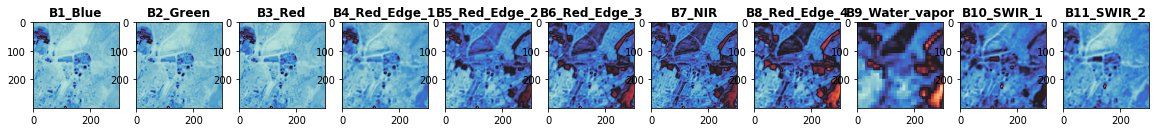

In [17]:
for cm in cms:
  f, axes = plt.subplots(1,s2_sample.count,figsize=(20,4))
  for i in range(1,s2_sample.count+1):
    show(s2_sample.read(i), ax=axes[i-1], title=bands_dictionary[i],cmap=cm)
  plt.show()


## Images colors histrograms and mask classes (on a single sample)

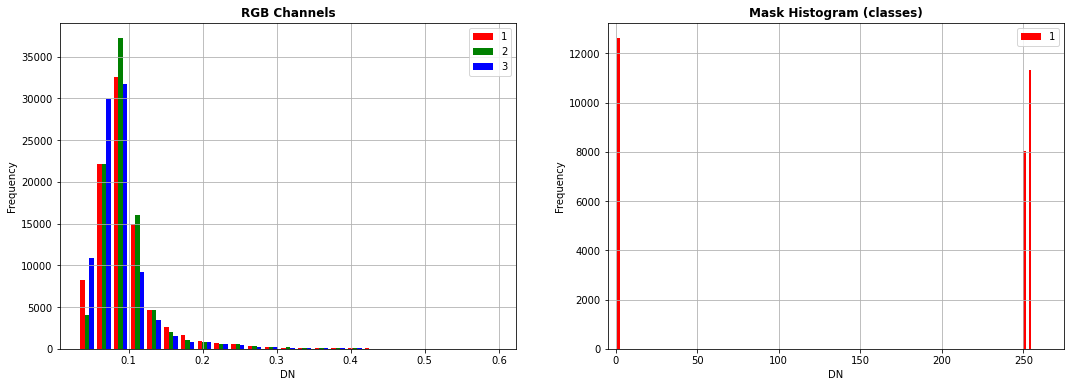

In [18]:
fig, (axh1, axh2) = plt.subplots(1,2, figsize=(18,6))
show_hist(s2_sample.read([3,2,1]), ax=axh1,bins=25, histtype='bar',title="RGB Channels")
axh2.set_xlim(-5, 275)
show_hist(esm_sample, ax=axh2,bins=150,  title="Mask Histogram (classes)")


# Preprocessing

1. Resize all multi channel S2 images to (15,300,300) - some of the images are with different dimensions
2. Align each mask to the S2 images Coordinate System (CRS) from CRS ESPG_3035 to ESPG_3857

## Reprojection using Rasterio

In [19]:
#Optionally removes spaces from image file names

#UNCOMMENT to rename images (remove spaces from the image names)
# rename_images(S2_DIR)

## Resizing input images to have the same dimensions (300x300) + Adding 4 new Bands Combinations

Simple Torch Resize in DataLoaders do not to work with the Multi bands images , only with images of 3 channels...

Adding new band to src images (inspired by Yoav Peled, and [this paper](https://www.researchgate.net/publication/330994618_Separating_Built-Up_Areas_from_Bare_Land_in_Mediterranean_Cities_Using_Sentinel-2A_Imagery))

(Note: B1 is Red , in the original S2 B2 is Red)


1. NDVI : Normalized difference vegetation index - Added as **B12**

$NIR-RED \over NIR+RED$=$B7-B3 \over B7+B3$

2. NDTI:Normalized Difference Tillage Index  - Added as **B13**

$(SWIR 1 - SWIR 2) \over (SWIR 1 + SWIR 2)$ = $(B10-B11) \over (B10+B11)$

3. NDVIre: Normalized Difference Vegetation Index  - Added as **B14**

$((RedEdge 1 - Red)) \over ((RedEdge 1 + Red))$ = $((B4 - B3)) \over ((B4 + B3))$

4. MNDWI: Modified Normalized Difference Water Index  - Added as **B15**

$ ((Green - SWIR 1))\over((Green + SWIR 1))$ = $ ((B2 - B10))\over((B2 + B10))$


<br>

In [22]:
#UNCOMMENT if you want to regenerate all images from source to target folders
# !rm -rf {EXPORT_DIR}/esm_aligned
# !rm -rf {EXPORT_DIR}/s2_resized

In [23]:
batch_resize(src_dir=S2_DIR,target_dir=s2_resized,n_bands=NUM_BANDS)


Source dir: /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2
Target dir: /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/
Creating  /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/
700 images to resize + additional 4 band to  (15, 300, 300)


  0%|          | 0/700 [00:00<?, ?it/s]

## Batch transforms ESM MASKs with 1 band into the the Sentinel2 image CRS


In [24]:
batch_projection(src_dir=ESM_DIR,target_dir=esm_aligned,orig_img_dir=s2_resized)

Source dir: /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM
Target dir: /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/
Orig images dir: /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/
Creating  /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/
700 images to transform


  0%|          | 0/700 [00:00<?, ?it/s]

## Validate that the generated masks and plot some samples of the transformed MASKs with original and matching image

Note: the class proprtions are saved, except for the **'no-data'** class (0) at the margins (white triangle areas), which are minimized due to the alignment (rotation).

In [25]:
cols = ['0','1','250','255']
df_orig_mask_class_counts = pd.DataFrame(columns=cols)
df_new_mask_class_counts = pd.DataFrame(columns=cols)

## Run dataset validation

Checks that the preprocessed images and masks metadata is aligned 


0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


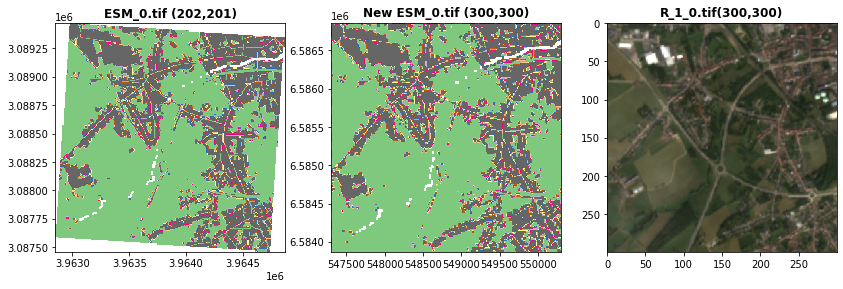

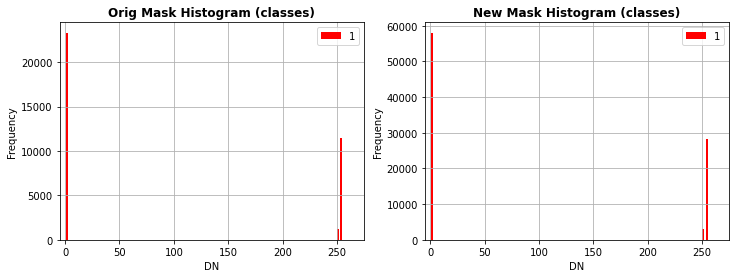

/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_0.tif classes: [  0   1 250 255]
['class:0,count:472700,11.64%:',
 'class:1,count:2330400,57.40%:',
 'class:250,count:117000,2.88%:',
 'class:255,count:1140100,28.08%:']
1  bands
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_0.tif classes: [  0   1 250 255]
['class:0,count:73100,0.81%:',
 'class:1,count:5802800,64.48%:',
 'class:250,count:289700,3.22%:',
 'class:255,count:2834400,31.49%:']
1  bands


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


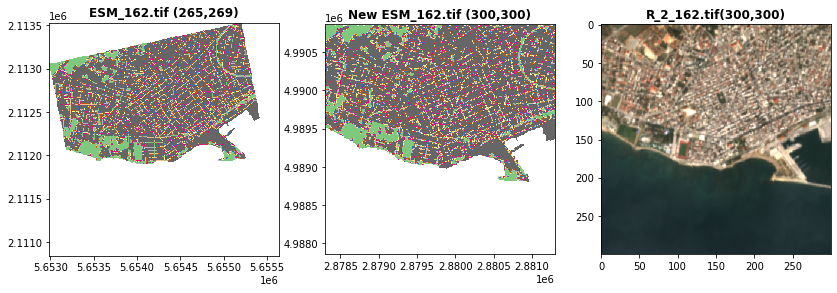

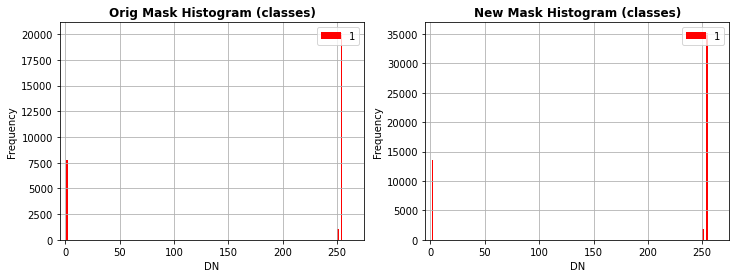

/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_162.tif classes: [  0   1 250 255]
['class:0,count:4230100,59.34%:',
 'class:1,count:778800,10.93%:',
 'class:250,count:104900,1.47%:',
 'class:255,count:2014700,28.26%:']
1  bands
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_162.tif classes: [  0   1 250 255]
['class:0,count:3932800,43.70%:',
 'class:1,count:1358600,15.10%:',
 'class:250,count:185900,2.07%:',
 'class:255,count:3522700,39.14%:']
1  bands


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


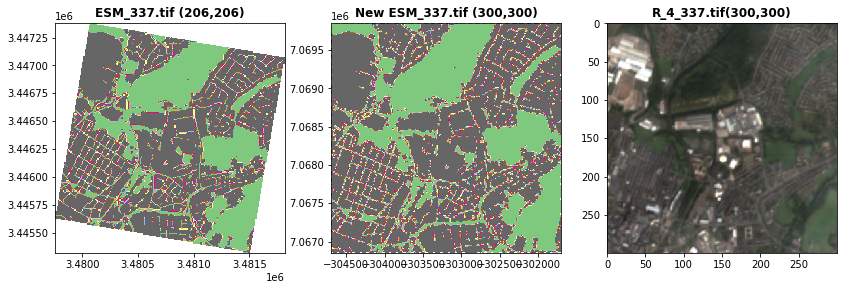

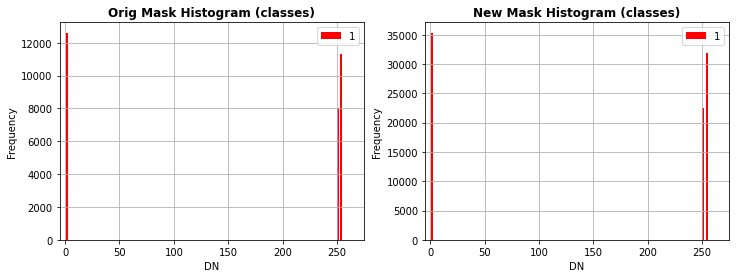

/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_337.tif classes: [  0   1 250 255]
['class:0,count:1047300,24.68%:',
 'class:1,count:1261200,29.72%:',
 'class:250,count:801600,18.89%:',
 'class:255,count:1133500,26.71%:']
1  bands
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_337.tif classes: [  0   1 250 255]
['class:0,count:24700,0.27%:',
 'class:1,count:3535000,39.28%:',
 'class:250,count:2252800,25.03%:',
 'class:255,count:3187500,35.42%:']
1  bands


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


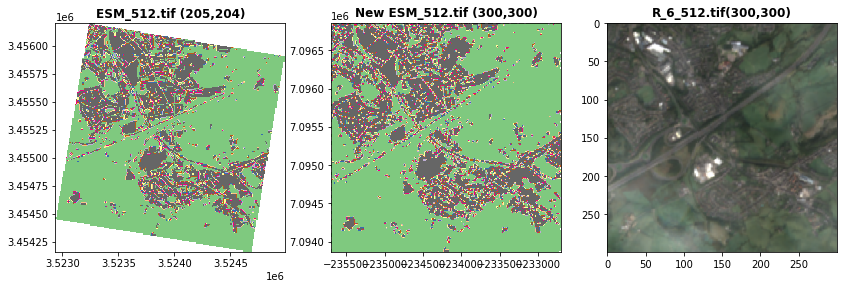

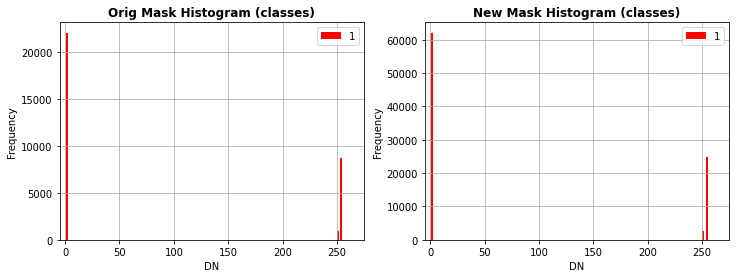

/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_512.tif classes: [  0   1 250 255]
['class:0,count:1007000,24.08%:',
 'class:1,count:2202900,52.68%:',
 'class:250,count:97500,2.33%:',
 'class:255,count:874600,20.91%:']
1  bands
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_512.tif classes: [  0   1 250 255]
['class:0,count:37800,0.42%:',
 'class:1,count:6210300,69.00%:',
 'class:250,count:277300,3.08%:',
 'class:255,count:2474600,27.50%:']
1  bands


In [26]:
orig_mask,new_mask,orig_img = None,None,None
orig_mask,new_mask,orig_img = validate_dataset(s2_resized,esm_aligned,
                                               ESM_DIR,df_orig_mask_class_counts,
                                               df_new_mask_class_counts)

In [27]:
if (new_mask != None):
  print('---------------------------------')
  print(orig_mask.name,'\n',orig_mask.meta)
  print('---------------------------------')
  print(new_mask.name,'\n',new_mask.meta)
  print('---------------------------------')
  print(orig_img.name,'\n',orig_img.meta)
  print('---------------------------------') 

---------------------------------
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/ESM/ESM_686.tif 
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 205, 'height': 205, 'count': 1, 'crs': CRS.from_epsg(3035), 'transform': Affine(10.0, 0.0, 3720930.0,
       0.0, -10.0, 3240350.0)}
---------------------------------
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_686.tif 
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 300, 'height': 300, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 139300.0,
       0.0, -10.0, 6790866.696607751)}
---------------------------------
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_7_686.tif 
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 300, 'height': 300, 'count': 15, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 139300.0,
       0.0, -10.0, 6790866.696607751)}
---------------------------------


## Validate the the class proportions were kept after the transformation

 (except for class 0 no_data which was minimized due to the rotation)

In [28]:
classes = ['0','1','250','255']
om=get_bu_area_ratio(df_orig_mask_class_counts,cols = classes)
nm=get_bu_area_ratio(df_new_mask_class_counts,cols = classes)

### Ratio of BU area comparison (without "no data" class)

We can see that due to the "no_data" shrinking, and the resize to 300x300 , the new distribution sum is larger, and it is a little shifted to the right compared to the original masks, but when taking out the no_data the distributions of before and after are very very close.

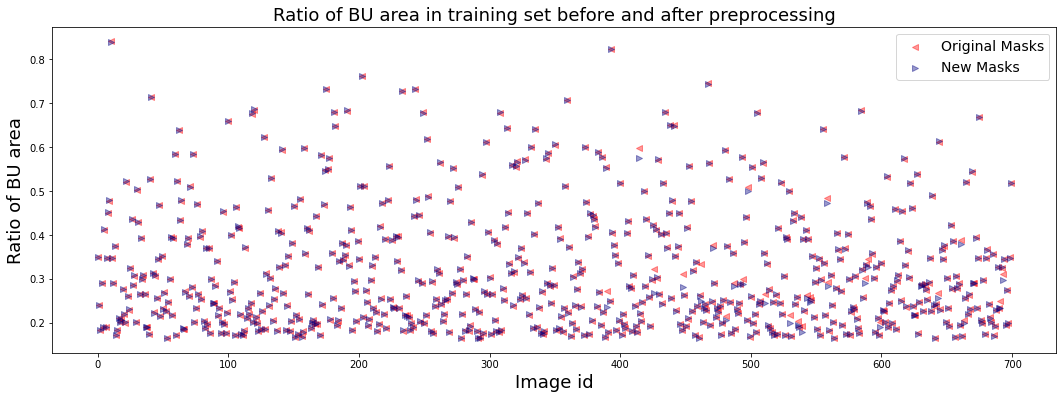

In [29]:
f,ax1 = plt.subplots(1,1,figsize=(18,6))
x1=om.index
y1=om
ax1.scatter(x1,y1,alpha=0.4,marker='<',color='red')

x2=nm.index
y2=nm
ax1.scatter(x2,y2,alpha=0.4,marker='>',color='navy')
ax1.set_xlabel('Image id',fontsize=18)
ax1.set_ylabel('Ratio of BU area',fontsize=18)
ax1.set_title('Ratio of BU area in training set before and after preprocessing',fontsize=18)
plt.legend({'Original Masks','New Masks'},fontsize=14)
plt.show()


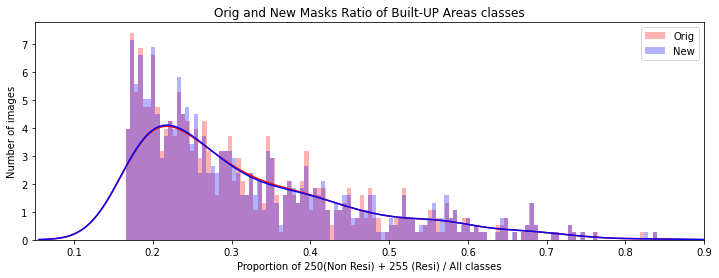

In [30]:
f,ax1 = plt.subplots(1,1,figsize=(12,4))

plot_hist(om,'',ax1,'Red',lbl='Orig')
plot_hist(nm,'Orig and New Masks Ratio of Built-UP Areas classes',ax1,'blue',lbl='New')
plt.show()


In [31]:
om.min(),om.max(),om.mean(),om.sum()

(0.16571978815599422,
 0.8404208680403332,
 0.31998689648251577,
 223.99082753776102)

In [32]:
nm.min(),nm.max(),nm.mean(),nm.sum()

(0.16555294012650743,
 0.8399057609244405,
 0.31941452460752756,
 223.5901672252693)

In [33]:
nm.to_csv('orig_masks_bu_area.csv',header=False)

In [34]:
get_bu_area_ratio(df_new_mask_class_counts,with_no_data=True,cols=classes).to_csv('orig_masks_bu_area_w_nodata.csv',header=False)

## Masks - Display Classes Imbalance

We can see that (as expected) there is a class imbalance.

- Class 1 - "Land / Other" is the most popular with 66%
- Class 255 - 'Residential' around 25%
- Class 250 - 'Non Residential' around 5%
- Class 0 - 'no data' - 4%

We need to deal with that in the Segmentation task by using:
1. Select a proper loss function (insensitive to the imbalance)
2. Augmentations + Upsampling of the lower classes

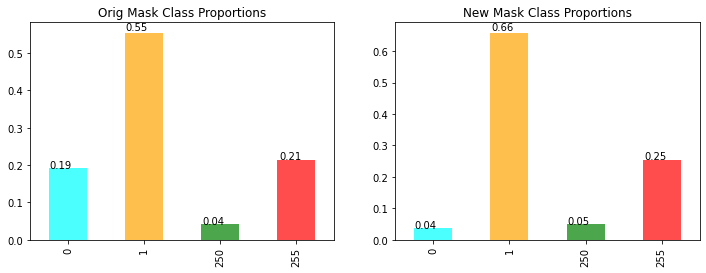

In [35]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

 
plot_simple_bar(df_orig_mask_class_counts,'Orig Mask Class Proportions',ax1)
plot_simple_bar(df_new_mask_class_counts,'New Mask Class Proportions',ax2)

for a in [ax1,ax2]:
  annotate(a)

plt.show()

In [36]:
df_new_mask_class_counts.to_csv('df_orig_mask_class_counts.csv',header=False)


# Generate the dataset statistics for later normalization during training

In [37]:
stats_mean_df,stats_std_df = calc_stats_dfs(img_path=s2_resized,n_bands=NUM_BANDS)       
stats_mean_df.head(3)

  0%|          | 0/700 [00:00<?, ?it/s]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.066742,0.088533,0.086858,0.127303,0.225129,0.259477,0.273611,0.277847,0.286784,0.200476,0.144928,0.504103,0.166276,0.207407,-0.395588
1,0.093488,0.118419,0.123021,0.163532,0.241001,0.270571,0.275663,0.285874,0.298707,0.246779,0.186028,0.370415,0.145956,0.149912,-0.343805
2,0.081833,0.110869,0.12025,0.163313,0.236564,0.262302,0.272449,0.282418,0.287662,0.26923,0.196165,0.39161,0.162746,0.166089,-0.423616


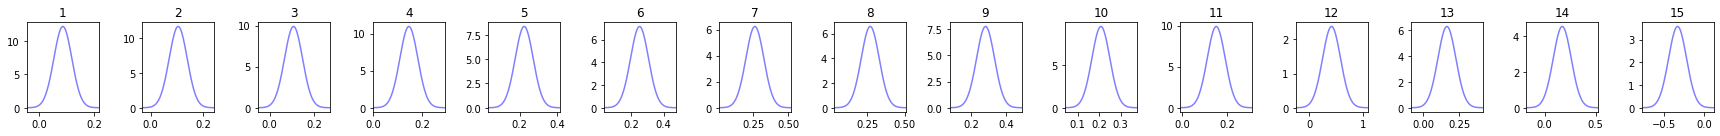

In [38]:
plot_bands_dist(NUM_BANDS,stats_mean_df,stats_std_df)

In [39]:
def plot_stats_dfs(mean_df,std_df,mean_df2=[],std_df2=[]):
  f,axs = plt.subplots(1,2,figsize=(20,6))
  mean_df.plot.box(ax=axs[0],color='blue')
  if(len(mean_df2)>0):
    mean_df2.plot.box(ax=axs[0],color='pink')
  axs[0].set_title('Means')
  std_df.plot.box(ax=axs[1],color='blue')
  if(len(std_df2)>0):
    std_df2.plot.box(ax=axs[1],color='pink')  
  axs[1].set_title('Stds')
  plt.suptitle('Different channels distributions')
  plt.show()

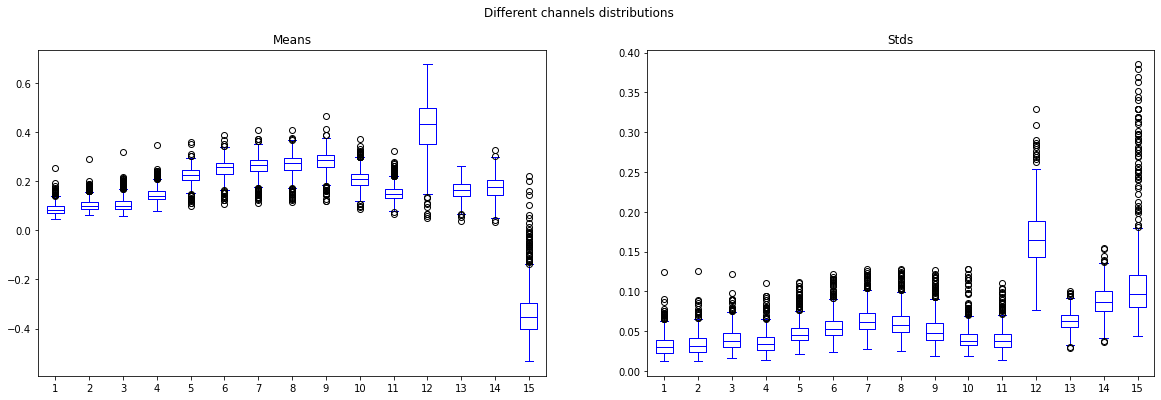

In [40]:
plot_stats_dfs(stats_mean_df,stats_std_df)

## Compare the original to newly preprocessed downloaded images

In [43]:
if(DOWN_PREP_DIR!=None):
  down_stats_mean_df,down_stats_std_df = calc_stats_dfs(DOWN_PREP_DIR,n_bands=NUM_BANDS)       
  display(down_stats_mean_df.head(3))

  0%|          | 0/49 [00:00<?, ?it/s]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.056194,0.071083,0.080346,0.098264,0.127145,0.140125,0.154814,0.153971,0.163436,0.160126,0.13344,0.303452,0.090171,0.119648,-0.396993
1,0.058925,0.071951,0.08116,0.096191,0.119291,0.130717,0.142823,0.142239,0.150611,0.150238,0.129387,0.262672,0.070903,0.102103,-0.365141
2,0.059381,0.081307,0.097281,0.121376,0.154178,0.16984,0.190571,0.188791,0.198143,0.200721,0.154484,0.294176,0.123805,0.115054,-0.407280


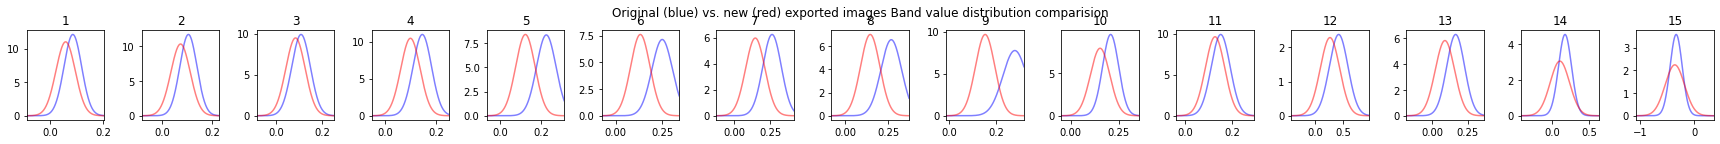

In [44]:
if(DOWN_PREP_DIR!=None):
  plot_bands_dist(NUM_BANDS,stats_mean_df,stats_std_df,down_stats_mean_df,down_stats_std_df)
  plt.suptitle('Original (blue) vs. new (red) exported images Band value distribution comparision')
  plt.tight_layout()
  plt.show()

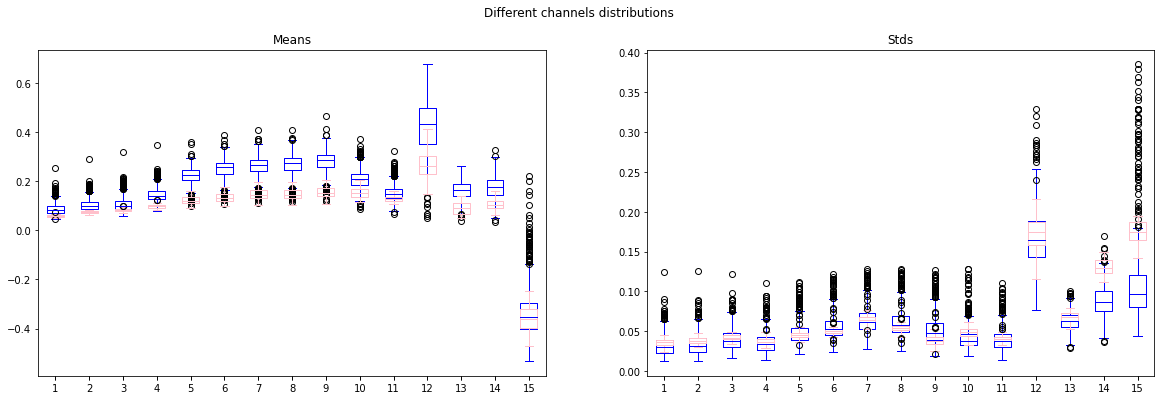

In [45]:
plot_stats_dfs(stats_mean_df,stats_std_df,down_stats_mean_df,down_stats_std_df)

## Saving the preprocessed statistics

This can be used for later imputation in case of nan values in exported images

In [46]:
stats_mean_df.to_csv('stats_mean_df.csv',header=True)
stats_std_df.to_csv('stats_std_df.csv',header=True)

!mkdir -p {META_DIR}
stats_mean_df.to_csv(META_DIR + 'down_stats_mean_df.csv',header=True)
stats_std_df.to_csv(META_DIR + 'down_stats_std_df.csv',header=True)

In [47]:
stats_mean_df333 = pd.read_csv('stats_mean_df.csv',header=0,index_col=0)
stats_mean_df333.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,0.085958,0.104924,0.106919,0.144985,0.223922,0.251056,0.262403,0.268294,0.280619,0.208505,0.151868,0.417858,0.164309,0.173535,-0.332371
std,0.025117,0.025247,0.030083,0.029344,0.032061,0.036920,0.038675,0.040166,0.042969,0.038592,0.033310,0.110126,0.037698,0.048936,0.107321
min,0.044437,0.062165,0.057224,0.076405,0.100271,0.107943,0.112709,0.113851,0.117997,0.085404,0.065496,0.049249,0.038890,0.034074,-0.532071
25%,0.068420,0.087243,0.085858,0.125658,0.205362,0.229683,0.240873,0.245057,0.256886,0.184831,0.130422,0.352911,0.140139,0.141719,-0.401250
50%,0.080652,0.099746,0.100415,0.139653,0.226446,0.255681,0.266537,0.273655,0.284770,0.206609,0.147188,0.431577,0.165553,0.175283,-0.351233
75%,0.097289,0.115295,0.119031,0.159142,0.243589,0.273748,0.286353,0.293779,0.307025,0.229672,0.166394,0.496359,0.189384,0.205330,-0.295071
max,0.254659,0.288837,0.318938,0.346174,0.360766,0.388548,0.408252,0.408352,0.464652,0.370197,0.324145,0.674846,0.260239,0.324859,0.221123


In [48]:
stats_mean_df333 = pd.read_csv('down_stats_mean_df.csv',header=0,index_col=0)
stats_mean_df333.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,0.059109,0.073589,0.082783,0.098304,0.121671,0.132959,0.146491,0.145105,0.154340,0.153500,0.127597,0.261536,0.088755,0.103714,-0.357344
std,0.004993,0.004641,0.006242,0.008971,0.015357,0.018016,0.022167,0.021710,0.022189,0.021050,0.011770,0.056678,0.026490,0.021516,0.052620
min,0.046562,0.063990,0.070347,0.084316,0.091423,0.097065,0.104154,0.102463,0.106922,0.115465,0.105621,0.148198,0.049665,0.060105,-0.470182
25%,0.055970,0.070797,0.078787,0.091858,0.110935,0.121065,0.131381,0.131267,0.141183,0.136794,0.117841,0.230210,0.064700,0.091482,-0.396993
50%,0.058925,0.072842,0.082073,0.097236,0.120368,0.130717,0.144599,0.142239,0.151735,0.151098,0.129261,0.262672,0.090009,0.102646,-0.361726
75%,0.062151,0.076927,0.085990,0.101958,0.133410,0.147056,0.163922,0.162987,0.170333,0.169954,0.134869,0.303452,0.112859,0.119648,-0.319329
max,0.072312,0.083448,0.099084,0.124754,0.159113,0.175073,0.196563,0.194622,0.202826,0.206559,0.158078,0.412006,0.140879,0.161042,-0.246364


In [49]:
def get_global_chn_mean(stats_mean_df333,band):
  print('Band:{} Mean:{:.6f}'.format(band,stats_mean_df[band].mean()))
  # stats_std_df = pd .read_csv('stats_std_df.csv',header=True)
for iii in range(1,16):
  get_global_chn_mean(stats_mean_df333,iii)

Band:1 Mean:0.085958
Band:2 Mean:0.104924
Band:3 Mean:0.106919
Band:4 Mean:0.144985
Band:5 Mean:0.223923
Band:6 Mean:0.251056
Band:7 Mean:0.262403
Band:8 Mean:0.268294
Band:9 Mean:0.280619
Band:10 Mean:0.208504
Band:11 Mean:0.151868
Band:12 Mean:0.417857
Band:13 Mean:0.164309
Band:14 Mean:0.173535
Band:15 Mean:-0.332371


# Feature selection - finding the most expressive bands

For Image similiarity we use both MSE and SSIM (Structural similarity index) https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html


In [50]:
s2_new_sample = glob.glob(s2_resized+ '/*.tif')[0]
s2_new_sample

'/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_0.tif'

In [51]:
new_esm_mask =Path(get_matching_mask_path(s2_new_sample.split('/')[-1],esm_aligned))
new_img = Path(get_matching_img_path(new_esm_mask.name,s2_resized))
new_esm_mask,new_img

(PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_0.tif'),
 PosixPath('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_0.tif'))

In [52]:
with rio.open(new_img) as ni:
  num_bands = ni.count

## Creating bands similiarity dataframes

currently on a single sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


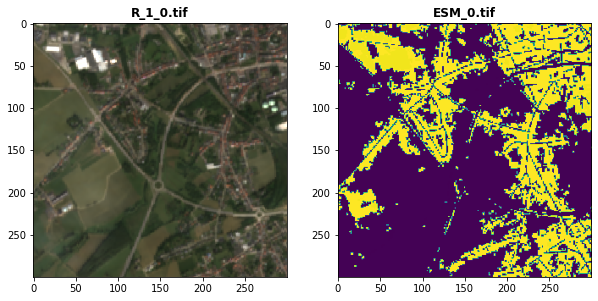

In [53]:
f,ax = plt.subplots(1,2,figsize=(10,6))
s2_sample = display_image(new_img,title=new_img.name,ax=ax[0])
new_esm_sample = display_image(new_esm_mask,bands=[1],title=new_esm_mask.name,ax=ax[1])

df_sim_ssim = pd.DataFrame(columns=range(1,NUM_BANDS),dtype=float)
df_sim_mse = pd.DataFrame(columns=range(1,NUM_BANDS),dtype=float)

cms = ['bwr']
for cm in cms:
  for i in range(1,s2_sample.count+1):
    img1 = s2_sample.read(i)
    for j in range(1,s2_sample.count+1):
      img2 = s2_sample.read(j)
      m,s = calc_similiarity(img1,img2)
      # print('Bands={}&{} \t MSE={} \t SSIM={}'.format(i,j,m,s))
      
      df_sim_ssim.loc[i,j] = s
      df_sim_mse.loc[i,j] = m


In [54]:
df_sim_ssim.shape

(15, 15)

## SSIM - similiarity between the ALL bands (for feature selection)

For feature selection

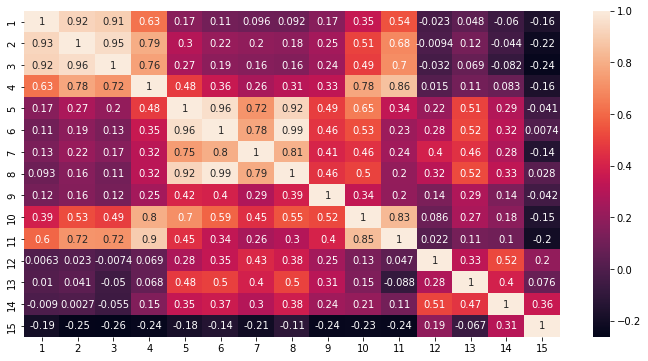

In [55]:
# Asymmetric - ssim(A,B) != ssim(B,A) - Higher is more similiar (Max 1)
f,ax=plt.subplots(1,1,figsize=(12,6))
# mask = np.triu(np.ones_like(df_sim_ssim, dtype=bool))
sns.heatmap(df_sim_ssim,annot=True)


Based on the SSIM we can see that:

-- RGB (1,2,3) are **very similiar** (thus we can select only one of them)

-- Bands 5,6,8 are **very similiar**

-- Bands 4,10,11 are quite **similiar**

-- Bands 12,13,14,15,7 and 9 are **unique**


We need to test if taking only 5 "distinct" ones is sufficient e.g. 1,4,6,7,9
(5 instead of 11 bands)

(The MSE comparison below shows more or less the same results)

In [56]:
for c in range(1,num_bands+1):
  ns=df_sim_ssim[c].nlargest(n=3).where(df_sim_ssim[c]>0.5)
  print('band {:2d},   most similiar bands: {}\t{}'.format(c,list(ns.index),ns.values))

band  1,   most similiar bands: [1, 2, 3]	[1.         0.92714188 0.91748332]
band  2,   most similiar bands: [2, 3, 1]	[1.         0.95565211 0.92351302]
band  3,   most similiar bands: [3, 2, 1]	[1.         0.95054778 0.90535661]
band  4,   most similiar bands: [4, 11, 10]	[1.         0.89531485 0.80238916]
band  5,   most similiar bands: [5, 6, 8]	[1.         0.95807315 0.92219384]
band  6,   most similiar bands: [6, 8, 5]	[1.         0.9875708  0.95840019]
band  7,   most similiar bands: [7, 8, 6]	[1.         0.79091206 0.77786238]
band  8,   most similiar bands: [8, 6, 5]	[1.         0.98736234 0.92164553]
band  9,   most similiar bands: [9, 10, 5]	[1.         0.51837834        nan]
band 10,   most similiar bands: [10, 11, 4]	[1.         0.84627848 0.7753576 ]
band 11,   most similiar bands: [11, 4, 10]	[1.         0.85881648 0.83373763]
band 12,   most similiar bands: [12, 14, 7]	[1.         0.50997401        nan]
band 13,   most similiar bands: [13, 8, 6]	[1.         0.52391814 0

## MSE similiarity between the ALL bands (for feature selection)

To see which are the most distinct bands for feature selection

## Comparing each band and mask similiarity (on a specific sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


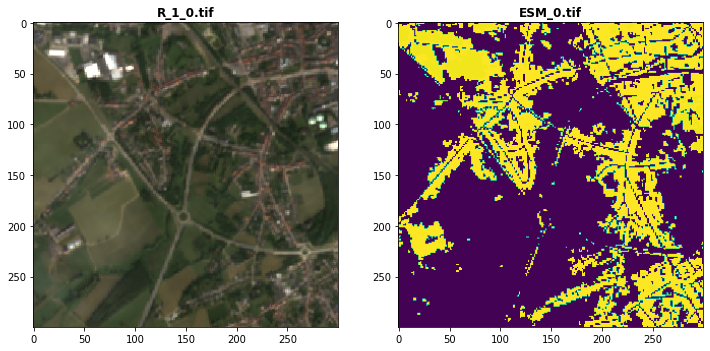

In [57]:
f,axs=plt.subplots(1,2,figsize=(12,6))

s2_sample = display_image(new_img,title=new_img.name,ax=axs[0])
new_esm_sample = display_image(new_esm_mask,bands=[1],title=new_esm_mask.name,ax=axs[1])

Mask & Band=1	SSIM=0.03624923636222898
Mask & Band=2	SSIM=0.05112527134361696
Mask & Band=3	SSIM=0.046744304869476574
Mask & Band=4	SSIM=0.06974592383099433
Mask & Band=5	SSIM=0.10002115043619522
Mask & Band=6	SSIM=0.10166440091427964
Mask & Band=7	SSIM=0.11196211165457816
Mask & Band=8	SSIM=0.1048122514731617
Mask & Band=9	SSIM=0.12486056267448682
Mask & Band=10	SSIM=0.10607327828820855
Mask & Band=11	SSIM=0.07953482118091801
Mask & Band=12	SSIM=0.16907069219923135
Mask & Band=13	SSIM=0.07584716239169957
Mask & Band=14	SSIM=0.07039098572337685
Mask & Band=15	SSIM=-0.1446159594533556


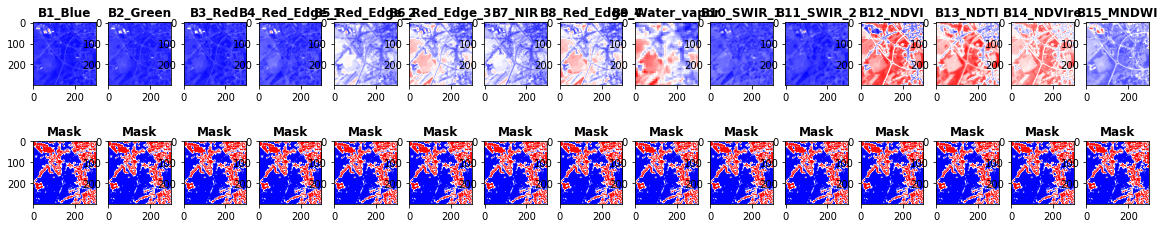

In [58]:
cms = ['bwr']
for cm in cms:
  f, axes = plt.subplots(2,num_bands,figsize=(20,4))
  for i in range(1,s2_sample.count+1):
    img = s2_sample.read(i)
    show(normalize(img), ax=axes[0,i-1], title=bands_dictionary[i].format(i),cmap=cm)
    # plt.suptitle(cm)
    msk=new_esm_sample.read(1)
    m,s = calc_similiarity(img,msk)
    print('Mask & Band={}\tSSIM={}'.format(i,s))
    show(msk, ax=axes[1,i-1], title='Mask',cmap=cm)
    
  plt.show()

calculate the similiarity between every band in every image to the matching image's mask (for bands , feature selection)

In [59]:
bands_sim_df = pd.DataFrame(columns=[v for v in bands_dictionary.values()])

SMALL_SIZE = 6
# matplotlib.rc('font', size=SMALL_SIZE)

s2_images = glob.glob(s2_resized + '/*.tif')

#iterate over all images
for image in tqdm(s2_images):
  img_bands_sim = []
  with rio.open(image,'r') as im:
    mask1 = get_matching_mask_path(image,esm_aligned)
    with rio.open(mask1,'r') as m1:
      msk1=np.array(m1.read(1))
      #iterate over all channels in image
      for c in range(1,im.count+1):
        chn1=np.array(im.read(c))
        _,s1 = calc_similiarity(chn1,msk1)
        img_bands_sim.append(s1)
  bands_sim_df.loc[len(bands_sim_df)] = img_bands_sim
print('Bands to Mask similiarity dataframe')
bands_sim_df.head(5)

  0%|          | 0/700 [00:00<?, ?it/s]

Bands to Mask similiarity dataframe


,B1_Blue,B2_Green,B3_Red,B4_Red_Edge_1,B5_Red_Edge_2,B6_Red_Edge_3,B7_NIR,B8_Red_Edge_4,B9_Water_vapor,B10_SWIR_1,B11_SWIR_2,B12_NDVI,B13_NDTI,B14_NDVIre,B15_MNDWI
0,0.036249,0.051125,0.046744,0.069746,0.100021,0.101664,0.111962,0.104812,0.124861,0.106073,0.079535,0.169071,0.075847,0.070391,-0.144616
1,0.088599,0.116972,0.115696,0.166392,0.229406,0.242594,0.243628,0.253174,0.267928,0.243769,0.178278,0.297527,0.135297,0.127949,-0.303342
2,0.058482,0.079788,0.079107,0.112249,0.141002,0.138782,0.142996,0.140345,0.139350,0.177996,0.134581,0.153996,0.105776,0.082625,-0.234021
3,0.038891,0.052785,0.048915,0.082087,0.111768,0.114275,0.090340,0.118947,0.183995,0.124802,0.087110,0.303857,0.144549,0.110094,-0.246736
4,0.021751,0.029729,0.029708,0.045291,0.055313,0.053810,0.047831,0.053491,0.053457,0.070006,0.056603,0.041106,0.040026,0.021725,-0.105481


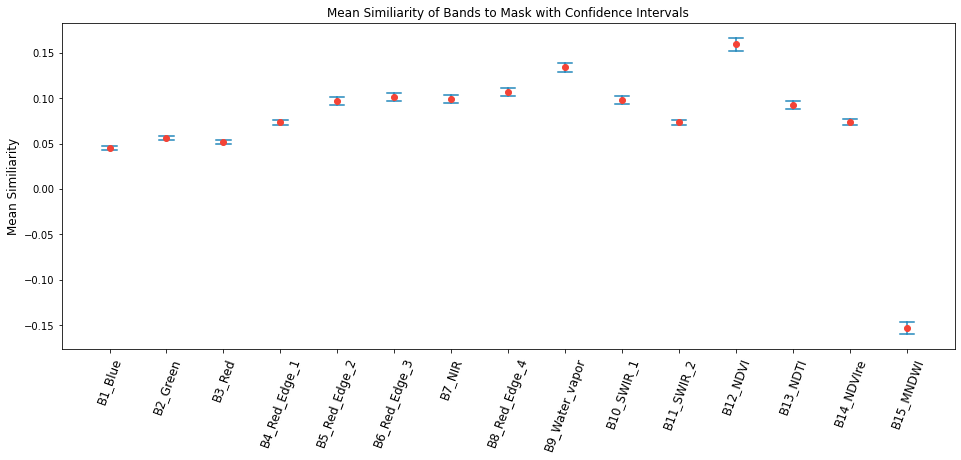

In [60]:
import matplotlib.pyplot as plt
import statistics
from math import sqrt

def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))
  
    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')
    plt.ylabel('Mean Similiarity',fontsize=SMALL_SIZE*2)

    return mean, confidence_interval

f,ax = plt.subplots(1,1,figsize=(16,6))
plt.xticks([i for i in range(len(bands_dictionary.values()))],
           [v for v in bands_dictionary.values()],rotation=70,fontsize=SMALL_SIZE*2)
plt.title('Mean Similiarity of Bands to Mask with Confidence Intervals',fontsize=SMALL_SIZE*2)
for i,b in enumerate(bands_sim_df.columns.values):
  plot_confidence_interval(i, bands_sim_df[b])


plt.show()

Create 650x15x15 matrix of bands pair similiarity

# Segmenation Experiments - Initial Results


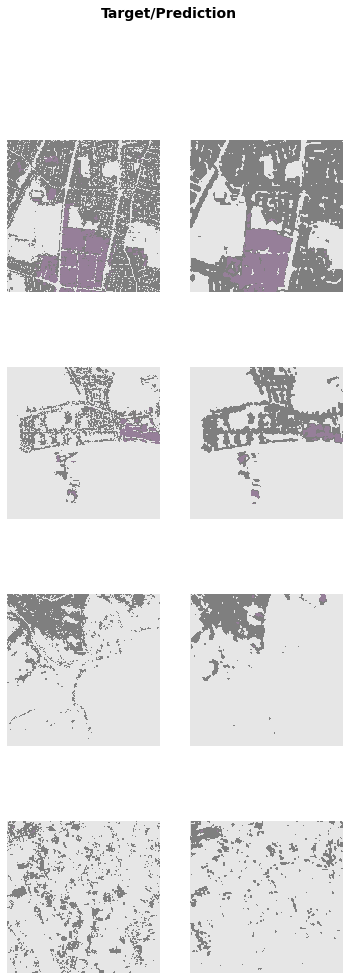